In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt

In [ ]:
t = jnp.linspace(0,10,30)
x = jnp.cos(t)[:,None]

Array([[ 1.        ],
       [ 0.94113375],
       [ 0.77146546],
       [ 0.51097062],
       [ 0.19031793],
       [-0.15274137],
       [-0.47781805],
       [-0.74664001],
       [-0.92755817],
       [-0.99927259],
       [-0.95334015],
       [-0.79516858],
       [-0.54337982],
       [-0.2276176 ],
       [ 0.11494261],
       [ 0.44397034],
       [ 0.72072833],
       [ 0.91263317],
       [ 0.99709142],
       [ 0.96415961],
       [ 0.81771487],
       [ 0.57499851],
       [ 0.26458613],
       [-0.07697663],
       [-0.40947674],
       [-0.69376812],
       [-0.89638045],
       [-0.99345967],
       [-0.97357639],
       [-0.83907153]], dtype=float64)

In [3]:
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
n_colloc = 500
colloc_weight = 50. * n_colloc * 3
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.25,alpha = 1.)
    )

# sparsifier = pySindySparsifier(
#     MIOSR(target_sparsity = 7,alpha = 0.1)
#     )


optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x'],
    input_orders = (0,1),
    ode_order = 2
)

# nodes,weights = legendre_nodes_weights(500,t0,t1)

model.fit(
    t,
    x,
)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.e-05, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 75000.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 3.054, gradnorm = 8.078e+03, alpha = 4.167, improvement_ratio = 0.9507
Iteration 1, loss = 0.1229, gradnorm = 1.259e+03, alpha = 3.472, improvement_ratio = 1.0
Iteration 2, loss = 0.08654, gradnorm = 73.46, alpha = 2.894, improvement_ratio = 0.9683
Iteration 3, loss = 0.06682, gradnorm = 66.13, alpha = 2.411, improvement_ratio = 0.9788
Iteration 4, loss = 0.05507, gradnorm = 37.75, alpha = 2.009, improvement_ratio = 0.9916
Iteration 5, loss = 0.04728, gradnorm = 17.15, alpha = 1.674, improvement_ratio = 0.9973
Iteration 88, loss = 0.007438, gradnorm = 3.84e-09, alpha = 1.424e+03, improvement_ratio = 4.542e+03
Model after smooth warm start
(x)'' = 0.004 1 + -0.999 x + -0.006 x^2 + 0.002 x (x') + -0.003 (x')^2
Alternating Activeset Sparsifier
5 active coeffs changed
Active set stabilized


In [4]:
model.print()

(x)'' = -0.999 x


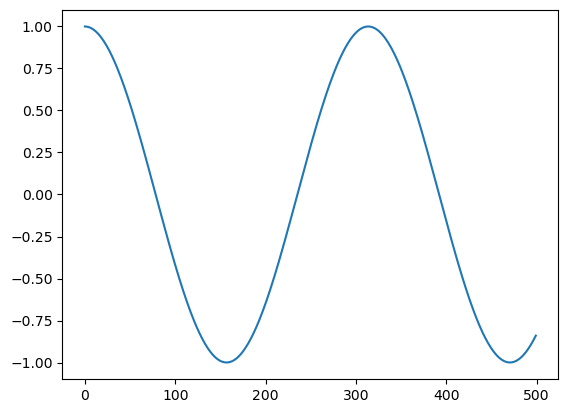

In [6]:
xx = model.predict_state(jnp.linspace(0,10,500))
plt.plot(xx[:,0])